## Perth Basin Case Study using Loop2Flopy


In [114]:
import numpy as np
import pandas as pd
import numbers
import LoopStructural



### Importing Borehole Data


In [141]:
bore_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="bore_info"
)

strat_info = pd.read_excel(
    "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
)

bore_info

,Easting,Northing,Source,ID,Ground,TQ,Tr,Tkm,Tk,Tkc,...,Kwlp,Kwlw,Kwlm,Kws,Kwg,Kpc,Kps,Kpo,Jy,Jc
0,-999.00,-999.00,PRAMS Formation Picks,JWS1,22.00,45,-,-,-,-,...,236,342,429,484,555,-,-,-,822,-
1,-999.00,-999.00,PRAMS Formation Picks,P7,67.00,6,-,-,-,-,...,-,256,277,350,-,555,-,-,-,-
2,-999.00,-999.00,PRAMS Formation Picks,WP,4.00,30,-,-,-,-,...,-,67,207,324,399,-,-,-,449,-
3,329743.00,6617059.00,PRAMS Formation Picks,ML8,39.00,24,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,387569.00,6613192.00,PRAMS Formation Picks,ML2,206.00,3,-,-,-,-,...,27,298,346,-,-,762,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,399250.86,6540082.42,East Midlands Completion report,NGG23B,215.54,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,385888.65,6578284.79,East Midlands Completion report,NGG24A,164.57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,385880.51,6578284.17,East Midlands Completion report,NGG24B,164.64,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,398143.55,6536728.06,East Midlands Completion report,GGB13C,120.73,0,NaN,NaN,NaN,NaN,...,135,272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter data

Crop to desired area and delete columns of less than 2 data points


In [142]:
df = bore_info.copy()
# x0, x1, y0, y1, z0, z1 = 355000, 402000, 6522000, 6534000, -1200, 200
x0, x1, y0, y1, z0, z1 = 355000, 402000, 6490000, 6540000, -1200, 200
, -1200, 200 # Whole Block
df = df.loc[(df["Northing"] >= y0)]
df = df.loc[(df["Northing"] <= y1)]
# df = df.loc[(df['Easting'] <= x1)]
df = df.drop(["Source"], axis=1)
# df = df.drop(['Tr','Tkm', 'Tk','Tkc','Jc','Kcom','Kps','Kpo','Kpc','Kcoh','Kcp'], axis=1)
# I think we need to keep this general so that we can apply it everywhere...
df = df.reset_index(drop=True)

df

,Easting,Northing,ID,Ground,TQ,Tr,Tkm,Tk,Tkc,Kcl,...,Kwlp,Kwlw,Kwlm,Kws,Kwg,Kpc,Kps,Kpo,Jy,Jc
0,394957.00,6539787.00,KR1,216.00,-,-,-,-,-,-,...,-,-,-,-,-,303,-,-,-,-
1,394957.00,6539787.00,KR5,216.00,3,-,-,-,-,-,...,155,216,-,-,-,220,-,-,-,-
2,397865.00,6539765.00,EXP2,230.00,2,-,-,-,-,-,...,116,155,-,-,-,-,-,-,-,-
3,406858.00,6538132.00,CUL1,179.00,3,-,-,-,-,-,...,313,-,-,-,-,-,-,-,-,-
4,404259.00,6537999.00,PRI1,208.00,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,379507.00,6530558.00,NG14A,52.17,54,-,-,-,-,-,...,-,229,252,269,-,-,-,-,311,NaN
99,388803.00,6530738.00,NGS1,8.00,46,-,-,-,-,-,...,-,-,-,-,-,-,84,-,-,NaN
100,391140.00,6525515.00,NGS2,61.00,35,-,-,-,-,-,...,-,-,-,-,-,-,61,-,-,NaN
101,398143.55,6536728.06,GGB13C,120.73,0,NaN,NaN,NaN,NaN,NaN,...,135,272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<bound method NDFrame.keys of        Easting    Northing       ID  Ground  TQ   Tr  Tkm   Tk  Tkc  Kcl  ...  \
0    394957.00  6539787.00      KR1  216.00   -    -    -    -    -    -  ...   
1    394957.00  6539787.00      KR5  216.00   3    -    -    -    -    -  ...   
2    397865.00  6539765.00     EXP2  230.00   2    -    -    -    -    -  ...   
3    406858.00  6538132.00     CUL1  179.00   3    -    -    -    -    -  ...   
4    404259.00  6537999.00     PRI1  208.00   -    -    -    -    -    -  ...   
..         ...         ...      ...     ...  ..  ...  ...  ...  ...  ...  ...   
98   379507.00  6530558.00    NG14A   52.17  54   -    -    -    -    -   ...   
99   388803.00  6530738.00     NGS1    8.00  46   -    -    -    -    -   ...   
100  391140.00  6525515.00     NGS2   61.00  35   -    -    -    -    -   ...   
101  398143.55  6536728.06  GGB13C   120.73   0  NaN  NaN  NaN  NaN  NaN  ...   
102  403803.89  6533984.43  GGB16C   137.60  10  NaN  NaN  NaN  NaN  NaN  ...  

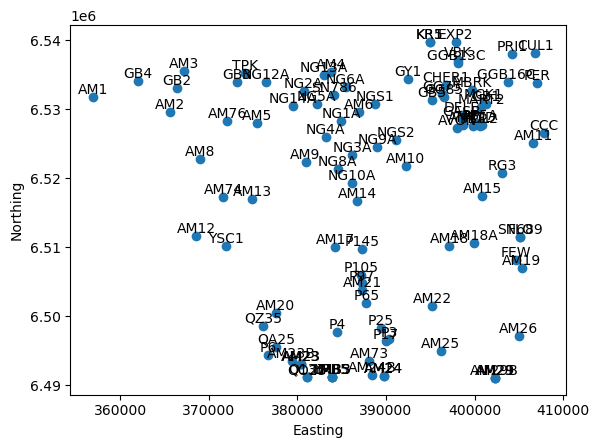

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

print(df.keys)

# Plan of data points
plt.scatter(df.Easting, df.Northing)
plt.xlabel("Easting")
plt.ylabel("Northing")
i = 0
for xi, yi in zip(df.Easting, df.Northing):
    plt.text(xi, yi, df.ID[i], va="bottom", ha="center")
    i += 1
# plt.plot([fx1, fx2], [fy1, fy2])
# plt.plot(fault_center[0], fault_center[1], 'o')
# plt.xlim(x0,x1)
# plt.ylim(y0,y1)

In [145]:
lithcodes = list(df.columns.values[3:])  # Make a list of formations
df.Easting = pd.to_numeric(df.Easting)
df.Northing = pd.to_numeric(df.Northing)
df.Ground = pd.to_numeric(df.Ground)
print(lithcodes)

['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


In [146]:
strat = []
vdum = [ 38,
        -10,
        -52,
        -124,
        -320,
        -385,
        -435,
        -463,
        -472,
        -494,
        -549,
        -591,
        -657,
        -685,
        -732,
        -888,
        -947,
        -1029,
        -1109,
        -1884,
        -2156,
        -2214,
        -3214,
        -4214
        ]

for i, lith in enumerate(lithcodes):
    index = i
    lithid = i - 1
    val = vdum[i]
    sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
    R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
    G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
    B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
    strat.append(
        [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
    )
strat = pd.DataFrame(strat)
strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]
strat

,index,lithid,lithcode,sequences,vals,color
0,0,-1,Ground,Quaternary,38,"[1.0, 1.0, 1.0]"
1,1,0,TQ,Quaternary,-10,"[1.0, 1.0, 0.0]"
2,2,1,Tr,Tertiary,-52,"[0.73, 0.6, 0.58]"
3,3,2,Tkm,Tertiary,-124,"[1.0, 0.6, 0.2]"
4,4,3,Tk,Tertiary,-320,"[1.12, 0.32, 0.16]"
5,5,4,Tkc,Tertiary,-385,"[1.0, 0.6, 0.2]"
6,6,5,Kcl,Coolyena_1a,-435,"[0.67, 0.8, 0.0]"
7,7,6,Kcp,Coolyena_1b,-463,"[0.77, 0.84, 0.61]"
8,8,7,Kcg,Coolyena_2,-472,"[0.67, 0.85, 0.6]"
9,9,8,Kcm,Coolyena_2,-494,"[0.67, 0.78, 0.71]"


### Make lithology table for Loop

#### A brief description of what we are trying to do.

So what we are trying to represent is the following

Feature 1:

Sky
Quaternary formations (superficial aquifer)

Quaternary unconformity.

As the Quaternary formation is everywhere, we can use this feature to develop the unconformity at the base of "TQ".

Feature 2:
Tertiary. okay not all are present here, but, generally no unconformities (you don't find a gap in the sequences)

Feature 3
Tertiary unconformity - Tertiary not always present, so create a seperate frature that has "zero" at the base of the deepest formation of tertiary age or younger.

Feature 4
Issue identified!!!!

Okay - usually you have Gingin / poison Hill Greensand, but not both.

# JP1 - Are these effectively the same but named twice of fundamentally different?

# JP2 - how to break up the coolyena

Feature 5
Coolyena unconfirmit -Coolyena not always present, so create a seperate frature that has "zero" at the base ofHenley sandstone or younger.

Feature 6
Warnbro

# JP3 Should we break this up into leederville and then SPS and Gage (some exceptions - Waneroo missing)

Feature 7
Warnbro unconformity (applied as before)

# JP4 Do you have coordinates for NGS1 and NGS2 (hit Parmelia)

Feature 8
Yaragadee / parmelia just not enough data - KPS on it's own KPO Carnac?

# JP5 NGG bores Leederville into uniits? (in cross sections but not in WIR)

# JP6 Petroleum bore gamma interpretation?


In [147]:
df

,Easting,Northing,ID,Ground,TQ,Tr,Tkm,Tk,Tkc,Kcl,...,Kwlp,Kwlw,Kwlm,Kws,Kwg,Kpc,Kps,Kpo,Jy,Jc
0,394957.00,6539787.00,KR1,216.00,-,-,-,-,-,-,...,-,-,-,-,-,303,-,-,-,-
1,394957.00,6539787.00,KR5,216.00,3,-,-,-,-,-,...,155,216,-,-,-,220,-,-,-,-
2,397865.00,6539765.00,EXP2,230.00,2,-,-,-,-,-,...,116,155,-,-,-,-,-,-,-,-
3,406858.00,6538132.00,CUL1,179.00,3,-,-,-,-,-,...,313,-,-,-,-,-,-,-,-,-
4,404259.00,6537999.00,PRI1,208.00,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,379507.00,6530558.00,NG14A,52.17,54,-,-,-,-,-,...,-,229,252,269,-,-,-,-,311,NaN
99,388803.00,6530738.00,NGS1,8.00,46,-,-,-,-,-,...,-,-,-,-,-,-,84,-,-,NaN
100,391140.00,6525515.00,NGS2,61.00,35,-,-,-,-,-,...,-,-,-,-,-,-,61,-,-,NaN
101,398143.55,6536728.06,GGB13C,120.73,0,NaN,NaN,NaN,NaN,NaN,...,135,272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# Okay, let me vocalise, or type, what is in my mind...
# So we treat the four parts as their own thing...
# then we make the unconformities feature names....
# Also, on the phone with JP, he said the last number is the end of hole (EOH)


data_list = df.values.tolist()  # Turn data into a list of lists
formatted_data = []
for i in range(len(data_list)):  # iterate for each row
    end = False
    # okay, first we will establish the max value (i.e. the end of the hole)
    stuff = []
    for j in range(3, 26, 1):
        if isinstance(data_list[i][j], numbers.Number) == True:
            stuff.append(data_list[i][j])

    EOH = max(stuff)
    #print(EOH)

    boreid = data_list[i][2]
    easting, northing = data_list[i][0], data_list[i][1]
    groundlevel = data_list[i][3]
    # First channp.nan, np.nan, np.nange - we can get the norms from the geophys data...
    gx, gy, gz = 0.0, 0.0, 1.0  # np.nan, np.nan,np.nan

    # Add data for groundlevel
    val = strat.vals[0]
    formatted_data.append(
        [
            boreid,
            easting,
            northing,
            groundlevel,
            val,
            "Ground",
            "Quaternary",
            gx,
            gy,
            gz,
        ]
    )  # eventually we cn get this from a dem...
    current_bottom = np.copy(groundlevel)

    # okay... lets see if the TQ boundary exists...
    # JP question - Say in SN786, how you have logged it, do you mean the Pinjar is at the surface?
    # thought 2 - we will just have a DEM eventaully I imagine... so ground could be an unconformity if we have something other than TQ at the surface?
    # but in the current framework:
    if isinstance(data_list[i][4], numbers.Number) == True:
        bottom = groundlevel - float(data_list[i][4])  # Ground surface - TQ (mbgl)
        val = strat.vals[1]  # designated isovalue
        lithid = lithcodes[1]  # lithology id
        feat_name = strat.sequences[1]  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz]
        )
        current_bottom = np.copy(bottom)
    non_conform = [0, #base Quaternary
                   4, #Base Tertiary
                   5, #Base lancelin
                   6, #Base Poison Hill
                   9,#Base Mirrabooka
                   12,#Base Henley
                   15,#Base Mariginiup
                   17,#Base Gage 
                   18,#Base Carnac
                   20,#Base Ottorowirri
                   21,#Base Yarragadee
                   22]
    non_conform_name = ["NC0","NC1","NC2","NC3","NC4","NC5","NC6","NC7","NC8","NC9","NC10","NC11"]
    gx, gy, gz = np.nan, np.nan,np.nan
    # I know, I know, there isn't any of the tertiary one here, but in being thorough...
    for j in range(5, 25, 1):
        if isinstance(data_list[i][j], numbers.Number) == True:
            if data_list[i][j] < EOH:
                bottom = groundlevel - float(
                    data_list[i][j]
                )  # Ground surface - TQ (mbgl)
                val = strat.vals[j - 3]  # designated isovalue
            else:
                bottom = np.copy(current_bottom)  # Ground surface - TQ (mbgl)
                val = strat.vals[j - 4]  # designated isovalue
                end = True

            lithid = lithcodes[j - 3]  # lithology id
            feat_name = strat.sequences[j - 3]  # sequence name
            formatted_data.append(
                [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz]
            )
            current_bottom = np.copy(bottom)
        #unconfirmities
        if strat.lithid[j - 3] in non_conform:
            if end == False:
                idx = non_conform.index(strat.lithid[j - 3])
                bottom = np.copy(current_bottom)
                val = 0.0
                lithid = non_conform_name[idx]
                feat_name = non_conform_name[idx] + '_FEAT' 
                formatted_data.append(
                    [boreid, easting, northing, bottom, val, lithid, feat_name, 0.0, 0.0, 1.0]
                )            
        





"""#Thomas Break up uncomformity 
X = np.loadtxt('../Geological_data/Geophysical_data/Thomas_transect/BU_thomas.dat')
for i in range(len(X)):
    val = 0.
    lithid = 'Warn_base'
    feat_name = 'WarnUC'
    formatted_data.append(['seis', X[i,0], X[i,1], X[i,2], val, lithid, feat_name, gx, gy, gz]) 

#Thomas Top_SPS
X = np.loadtxt('../Geological_data/Geophysical_data/Thomas_transect/Top_SPS_thomas.dat')
for i in range(len(X)):
    val = vdum[16]
    feat_name = strat.sequences[16] 
    lithid    = lithcodes[16]
    formatted_data.append(['seis', X[i,0], X[i,1], X[i,2], val, lithid, feat_name, gx, gy, gz])"""

data = pd.DataFrame(formatted_data)
data.columns = [
    "ID",
    "X",
    "Y",
    "Z",
    "val",
    "lithcode",
    "feature_name",
    "gx",
    "gy",
    "gz",
]

#### Fault stuff


In [134]:
# The Bado
fx1, fx2 = 373786, 373439
fy1, fy2 = 6528191, 6517059
fz = -800  # [-200,-500]

fault_azimuth = 90 - np.rad2deg(np.arctan(np.abs(fy2 - fy1) / np.abs(fx2 - fx1)))
fault_center = [fx1 + (fx2 - fx1) / 2, fy1 + (fy2 - fy1) / 2, fz]
fault_max_disp = 500.0  # 200?
fault_slip_vector = [0, 0, 1]
major_axis = (
    100000  # np.sqrt((fx2 - fx1)**2 + (fy2 - fy1)**2)/2 # fault_extent - along fault
)
minor_axis = 100000  # Fault_influence - orthogonal to fault
intermediate_axis = 0  # fault_vertical_radius
strike, dip = fault_azimuth, 270

# Make cloud of points along fault plane
nh = 50  # points  in x/y plane
x_array, y_array = [], []  # arrays to create points along fault
x_array.append(fx1)
y_array.append(fy1)
for i in range(nh - 2):
    x_array.append(fx1 + (i + 1) * (fx2 - fx1) / (nh - 1))
    y_array.append(fy1 + (i + 1) * (fy2 - fy1) / (nh - 1))
x_array.append(fx2)
y_array.append(fy2)

z_array = np.arange(-1000, 0, 50)
nv = len(z_array)  # points in z plane

from LoopStructural.utils import strikedip2vector as strike_dip_vector

nx, ny, nz = strike_dip_vector([strike], [dip])[0]
print(nx, ny, nz)

fault_plane_3d = []
for v in range(nv):  # vertical points
    for h in range(nh):  # horizontal points
        x, y, z = x_array[h], y_array[h], z_array[v]
        fault_plane_3d.append((x, y, z))
        df_new_row = pd.DataFrame.from_records(
            {
                "X": [x],
                "Y": [y],
                "Z": [z],
                "val": [0.0],
                "feature_name": ["Fault"],
                "nx": [nx],
                "ny": [ny],
                "nz": [nz],
            }
        )
        data = pd.concat([data, df_new_row], ignore_index=True)

## ADD FAULT (this chunk given to me directly by Lachlan Grose to make an ellipsoid fault)
from LoopStructural.modelling.features.fault._fault_function import (
    CubicFunction,
    FaultDisplacement,
    Composite,
)

hw = CubicFunction()
hw.add_cstr(0, 1)
hw.add_grad(0, 0)
hw.add_cstr(1, 0)
hw.add_grad(1, 0)
hw.add_max(1)
fw = CubicFunction()
fw.add_cstr(0, -1)
fw.add_grad(0, 0)
fw.add_cstr(-1, 0)
fw.add_grad(-1, 0)
fw.add_min(-1)
gyf = CubicFunction()
gyf.add_cstr(-1, 0)
gyf.add_cstr(1, 0)
gyf.add_cstr(-0.2, 1)
gyf.add_cstr(0.2, 1)
gyf.add_grad(0, 0)
gyf.add_min(-1)
gyf.add_max(1)
gzf = CubicFunction()
gzf.add_cstr(-1, 0)
gzf.add_cstr(1, 0)
gzf.add_cstr(-0.2, 1)
gzf.add_cstr(0.2, 1)
gzf.add_grad(0, 0)
gzf.add_min(-1)
gzf.add_max(1)
gxf = Composite(hw, fw)
fault_displacement = None
fault_displacement = FaultDisplacement(gx=gxf, gy=gyf, gz=gzf)
faultfunction = fault_displacement

-0.9995145257373308 0.031156264860838546 -1.8369701987210297e-16


In [135]:
for lith in lithcodes:
    filtered_df = data[data.lithcode == lith]
    print(
        "\n Lithology = ",
        lith,
        "\n\n",
        filtered_df[
            ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
        ],
    )

filtered_df = data[data.lithcode == "Tert_base"]
print(
    "\n Lithology = ",
    lith,
    "\n\n",
    filtered_df[
        ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
    ],
)
filtered_df = data[data.lithcode == "Cool_base"]
print(
    "\n Lithology = ",
    lith,
    "\n\n",
    filtered_df[
        ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
    ],
)
filtered_df = data[data.lithcode == "Warn_base"]
print(
    "\n Lithology = ",
    lith,
    "\n\n",
    filtered_df[
        ["ID", "X", "Y", "Z", "val", "lithcode", "feature_name", "gx", "gy", "gz"]
    ],
)


 Lithology =  Ground 

            ID          X           Y       Z   val lithcode feature_name   gx  \
0         KR1  394957.00  6539787.00   216.0  38.0   Ground   Quaternary  0.0   
7         KR5  394957.00  6539787.00   216.0  38.0   Ground   Quaternary  0.0   
20       EXP2  397865.00  6539765.00   230.0  38.0   Ground   Quaternary  0.0   
34       CUL1  406858.00  6538132.00   179.0  38.0   Ground   Quaternary  0.0   
47       PRI1  404259.00  6537999.00   208.0  38.0   Ground   Quaternary  0.0   
...       ...        ...         ...     ...   ...      ...          ...  ...   
1244    NG14A  379507.00  6530558.00   52.17  38.0   Ground   Quaternary  0.0   
1254     NGS1  388803.00  6530738.00     8.0  38.0   Ground   Quaternary  0.0   
1262     NGS2  391140.00  6525515.00    61.0  38.0   Ground   Quaternary  0.0   
1270  GGB13C   398143.55  6536728.06  120.73  38.0   Ground   Quaternary  0.0   
1292  GGB16C   403803.89  6533984.43   137.6  38.0   Ground   Quaternary  0.0   

  

### Create Geomodel


In [136]:
from LoopStructural import GeologicalModel

origin = np.array([x0, y0, z0]).astype(float)
maximum = np.array([x1, y1, z1]).astype(float)

geomodel_strat_column = GeologicalModel(
    origin, maximum
)  # Made using unconformities and a strat column
geomodel_strat_column.data = data

In [137]:
origin, maximum

(array([ 3.55e+05,  6.49e+06, -1.20e+03]),
 array([4.02e+05, 6.54e+06, 2.00e+02]))

In [138]:
np.isnan(origin)

array([False, False, False])

In [139]:
data["Z"] = data["Z"].astype(float)

### Add surfaces


In [140]:
origin = np.array([3.55e05, 6.49e06, -1.20e03])
maximum = np.array([4.02e05, 6.54e06, 2.00e02])
# data = pd.read_csv("ls_data.csv")

geomodel_strat_column = GeologicalModel(
    origin, maximum
)  # Made using unconformities and a strat column
geomodel_strat_column.data = data

#First add the quaternary formations

Quat = geomodel_strat_column.create_and_add_foliation(
    "Quaternary", nelements=1e4, buffer=0.1
)

#This is the unconfrmity at the bas of the model
UC0 = geomodel_strat_column.add_unconformity(geomodel_strat_column["Quaternary"], -10)
#When all present, the tertiary units appear conformable, so we can have them present
Tert = geomodel_strat_column.create_and_add_foliation(
    "Tertiary", nelements=1e4, buffer=0.1
)

#This is a seperate foliation for the tertiary unconformity
TertUC = geomodel_strat_column.create_and_add_foliation(
    "NC1_FEAT", nelements=1e4, buffer=0.1
)

UC1 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC1_FEAT"], 0
)

# The Coolyena is interesting, but the grouping have been made based on if the units appear conformable or not.
#The Lancelin gets it's own
Cool_1a = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_1a", nelements=1e4, buffer=0.1
)

Lancelin_UC = geomodel_strat_column.create_and_add_foliation(
    "NC2_FEAT", nelements=1e4, buffer=0.1
)

UC2 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC2_FEAT"], 0
)
#The Poison Hill gets it's own
Cool_1b = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_1b", nelements=1e4, buffer=0.1
)

Poison_hill_UC = geomodel_strat_column.create_and_add_foliation(
    "NC3_FEAT", nelements=1e4, buffer=0.1
)

UC3 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC3_FEAT"], 0
)
#Then I have grouped the Gingin Chalk. Molecap and... the mirrabooka. Now this is part of the osbourne, 
#but sometimes the Kardinya Shale is absent, so there can be mirabooka over Henley which makes life hard.

Cool_2 = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_2", nelements=1e4, buffer=0.1
)

Mirrabooka_UC = geomodel_strat_column.create_and_add_foliation(
    "NC4_FEAT", nelements=1e4, buffer=0.1
)

UC4 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC4_FEAT"], 0
)

#Then I have the Kardinya and Henley together

Cool_3 = geomodel_strat_column.create_and_add_foliation(
    "Coolyena_3", nelements=1e4, buffer=0.1
)

Henley_UC = geomodel_strat_column.create_and_add_foliation(
    "NC5_FEAT", nelements=1e4, buffer=0.1
)

UC5 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC5_FEAT"], 0
)


#Then we add the Fault.

fault_slip_vector = [0, 0, 1]
major_axis = (
    100000  # np.sqrt((fx2 - fx1)**2 + (fy2 - fy1)**2)/2 # fault_extent - along fault
)
minor_axis = 100000  #


Fault_1 = geomodel_strat_column.create_and_add_fault(
    "Fault",
    displacement=500.0,
    fault_slip_vector=fault_slip_vector,
    # fault_center = fault_center,
    minor_axis=10000,  # minor_axis,  # fault_influence
    # major_axis = major_axis, # fault_extent
    # intermediate_axis = intermediate_axis, # fault_vertical_radius
    # aultfunction = faultfunction, #faultfunction in routines.ipynb
    # nelements=4000, steps=4, interpolatortype="FDI", buffer=0.3, solver='pyamg',
    force_mesh_geometry=False,
    nelements=1e3,
)

#Leederville units seem conformable

LEED = geomodel_strat_column.create_and_add_foliation(
    "Leederville", nelements=1e4, buffer=0.1
)

LEED_UC = geomodel_strat_column.create_and_add_foliation(
    "NC6_FEAT", nelements=1e4, buffer=0.1
)

UC6 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC6_FEAT"], 0
)

#SPS and/ or Gage can go missing 
WARN = geomodel_strat_column.create_and_add_foliation(
    "Warnbro", nelements=1e4, buffer=0.1
)

WARN_UC = geomodel_strat_column.create_and_add_foliation(
    "NC7_FEAT", nelements=1e4, buffer=0.1
)

UC7 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC7_FEAT"], 0
)

#Carnac is just unusual, but sometimes it can overly the ottorowirri directly.
CARN = geomodel_strat_column.create_and_add_foliation(
    "Carnac", nelements=1e4, buffer=0.1
)

CARN_UC = geomodel_strat_column.create_and_add_foliation(
    "NC8_FEAT", nelements=1e4, buffer=0.1
)

UC8 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC8_FEAT"], 0
)

#We can assume parmelia and ottorowirri are conformable.
PARM = geomodel_strat_column.create_and_add_foliation(
    "Parmelia", nelements=1e4, buffer=0.1
)

PARM_UC = geomodel_strat_column.create_and_add_foliation(
    "NC9_FEAT", nelements=1e4, buffer=0.1
)

UC9 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC9_FEAT"], 0
)

YARR = geomodel_strat_column.create_and_add_foliation(
    "Yarragadee", nelements=1e4, buffer=0.1
)

"""YARR_UC = geomodel_strat_column.create_and_add_foliation(
    "NC10_FEAT", nelements=1e4, buffer=0.1
)

UC10 = geomodel_strat_column.add_onlap_unconformity(
    geomodel_strat_column["NC10_FEAT"], 0
)"""



ValueError: NC5_FEAT does not exist!

### Add Stratigraphy Column


In [112]:
stratigraphic_column = {}
stratigraphic_column["Quaternary"] = {}
stratigraphic_column["Tertiary"] = {}
stratigraphic_column["Coolyena_1a"] = {}
stratigraphic_column["Coolyena_1b"] = {}
stratigraphic_column["Coolyena_2"] = {}
stratigraphic_column["Coolyena_3"] = {}
stratigraphic_column["Leederville"] = {}
stratigraphic_column["Warnbro"] = {}
stratigraphic_column["Carnac"] = {}
stratigraphic_column["Parmelia"] = {}
stratigraphic_column["Yarragadee"] = {}

tops = [0,2,6,7,8,11,14,17,19,20,22]
bots = [1,5,6,7,10,13,16,18,19,21,22]
for i in range(1, len(strat) - 1, 1):
    if i in tops:
        maxval = np.inf
    else:
        maxval = strat.vals[i - 1]
    if i in bots:
         minval = -np.inf
    else:
        minval = strat.vals[i]       
    stratigraphic_column[strat.sequences[i]][strat.lithcode[i]] = {
        "min": minval,
        "max": maxval,
        "id": i,
        "color": strat.color[i],
    }

geomodel_strat_column.set_stratigraphic_column(stratigraphic_column)
# geomodel_strat_column.update()

# geomodel_scalar_field.update()
stratigraphic_column

{'Quaternary': {'TQ': {'min': -inf,
   'max': 38,
   'id': 1,
   'color': [1.0, 1.0, 0.0],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])}},
 'Tertiary': {'Tr': {'min': -52,
   'max': inf,
   'id': 2,
   'color': [0.73, 0.6, 0.58],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])},
  'Tkm': {'min': -124,
   'max': -52,
   'id': 3,
   'color': [1.0, 0.6, 0.2],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])},
  'Tk': {'min': -320,
   'max': -124,
   'id': 4,
   'color': [1.12, 0.32, 0.16],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])},
  'Tkc': {'min': -inf,
   'max': -320,
   'id': 5,
   'color': [1.0, 0.6, 0.2],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])}},
 'Coolyena_1a': {'Kcl': {'min': -inf,
   'max': inf,
   'id': 6,
   'color': [0.67, 0.8, 0.0],
   'colour': array([0.12156863, 0.46666667, 0.70588235, 1.        ])}},
 'Coolyena_1b': {'Kcp': {'min': -inf,
   'max': inf,


### 2D View


In [106]:
fault_max_disp

500.0

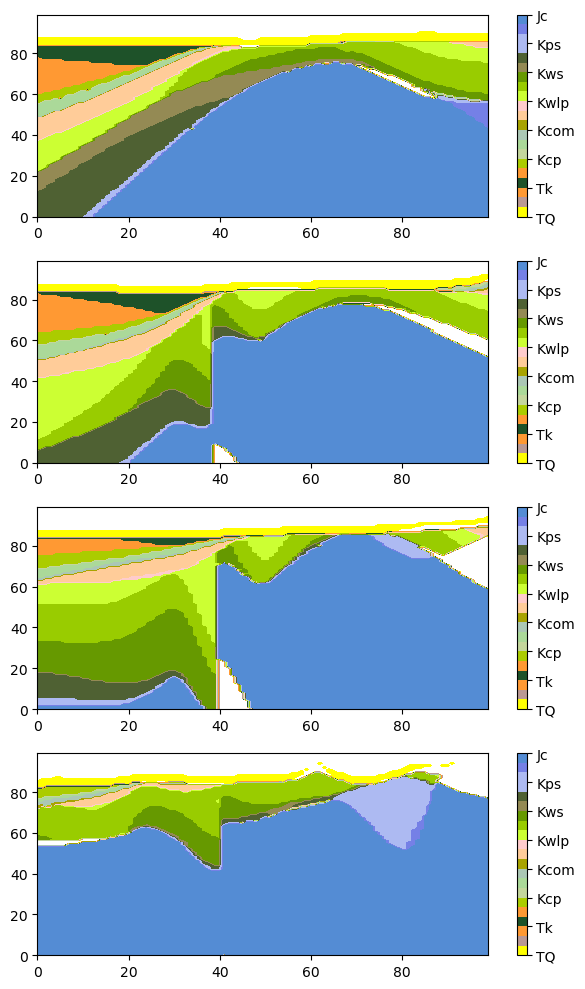

In [113]:
y_transects = [
    6505000,
    6515000,
    6525000,
    6532000,
]

delx, delz = 100, 100

x, z = np.linspace(x0, x1, delx), np.linspace(z0, z1, delz)

xx, zz = np.meshgrid(x, z)

V_strat_column = []

V_scalar_field = []
i = 0

plt.figure(figsize=(12, 10))

for i in range(4):

    yy = np.zeros_like(xx)

    yy[:] = y_transects[i]

    # X_sect = geomodel.evaluate_model(np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T).reshape(np.shape(xx))

    # test = geomodel_strat_column.evaluate_feature_value(
    #     "Tertiary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # # plt.imshow(vals2)

    V_strat_column.append(
        geomodel_strat_column.evaluate_model(
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx))
    )
    plt.subplot(4, 2, i * 2 + 2)
    # plt.contourf(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     10,
    # )
    # plt.contourf(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     10,
    # )
    plt.contourf(
        V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        colors=strat["color"][1:],
    )
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(lithcodes[1:])
    # plt.title("Y = " + str(y_transects[i]) + " Strat Column")
    # plt.xticks(
    #     [0, 20, 40, 60, 80, 100],
    #     [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    # )
    # plt.xlabel("Easting (m)")
    # yticks = []
    # yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    # for ydum in yvals:
    #     n = np.argmin(abs(ydum - z))
    #     yticks.append(n)
    # plt.yticks(yticks, yvals)
    # plt.ylabel("z mAHD)")
    # plt.contour(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "Fault", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     [0],
    # )
    # # plt.contourf(
    # #     geomodel_strat_column.evaluate_feature_value(
    # #         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # #     ).reshape(np.shape(xx)),
    # #     10,
    # # )
    # # plt.contourf(
    # #     geomodel_strat_column['Fault'].displacementfeature.evaluate_value(
    # #         geomodel_strat_column.scale(np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T)
    # #     ).reshape(np.shape(xx)),
    # #     10,
    # # )
    # plt.contour(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "CoolUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     0,
    # )
    # plt.contour(
    #     geomodel_strat_column.evaluate_feature_value(
    #         "WarnUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    #     ).reshape(np.shape(xx)),
    #     0,
    # )
    # # plt.contourf(
    # #     geomodel_strat_column.evaluate_feature_value(
    # #         "Fault", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # #     ).reshape(np.shape(xx)),
    # #     0,
    # )
plt.tight_layout()

In [108]:
vf = geomodel_strat_column["Fault"][1].vector_field()

In [109]:
ps = geomodel_strat_column.data[["X", "Y", "Z"]].values
vf = geomodel_strat_column["Fault"][1].evaluate_gradient(ps)

In [110]:
import pyvista as pv

points = pv.PolyData(vf.locations)
points.point_data.set_vectors(vf.vectors, "vectors")
geom = pv.Arrow()

AttributeError: 'numpy.ndarray' object has no attribute 'locations'

In [ ]:
vectorfield = points.glyph(
    scale="vectors", orient="vectors", geom=geom, tolerance=0.05, factor=100
)

In [ ]:
stratigraphic_column["Yarragadee"]Z

In [ ]:
import pyvista as pv

p = pv.Plotter(notebook=True)
p.add_mesh(
    geomodel_strat_column["Fault"].displacementfeature.scalar_field(
        geomodel_strat_column.bounding_box
    )
)
# p.add_mesh(geomodel_strat_column["Fault"][0].surfaces(0)[0].vtk)
# for u in stratigraphic_column["Yarragadee"].values():
#     print(u["min"])
#     p.add_mesh(geomodel_strat_column["Yarragadee"].surfaces([u['min']])[0].vtk)
# p.add_mesh(geomodel_strat_column['CoolUC'].surfaces(0)[0].vtk)
p.show()

In [ ]:
geomodel_strat_column["Yarragadee"].faults

In [ ]:
geomodel_strat_column["Yarragadee"].surfaces(
    (
        geomodel_strat_column["Yarragadee"].max()
        - geomodel_strat_column["Yarragadee"].min()
    )
    + geomodel_strat_column["Yarragadee"].min()
)

In [89]:
geomodel_strat_column["Yarragadee"].faults

[]

In [ ]:
# plt.imshow(Lith,origin = 'lower')
plt.figure(figsize=(12, 10))
for i in range(4):
    # plt.subplot(4, 2, i * 2 + 1)
    # plt.contourf(
    #     V_scalar_field[i],
    #     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    #     colors=strat["color"][1:],
    # )
    # cbar = plt.colorbar()
    # cbar.ax.set_yticklabels(lithcodes[1:])
    # plt.title("Y = " + str(y_transects[i]) + " Scalar Field")
    # plt.xticks(
    #     [0, 20, 40, 60, 80, 100],
    #     [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    # )
    # plt.xlabel("Easting (m)")
    # yticks = []
    # yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    # for ydum in yvals:
    #     n = np.argmin(abs(ydum - z))
    #     yticks.append(n)
    # plt.yticks(yticks, yvals)
    # plt.ylabel("z mAHD)")

    plt.subplot(4, 2, i * 2 + 2)

    plt.contourf(
        V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        colors=strat["color"][1:],
    )
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(lithcodes[1:])
    plt.title("Y = " + str(y_transects[i]) + " Strat Column")
    plt.xticks(
        [0, 20, 40, 60, 80, 100],
        [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    )
    plt.xlabel("Easting (m)")
    yticks = []
    yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    for ydum in yvals:
        n = np.argmin(abs(ydum - z))
        yticks.append(n)
    plt.yticks(yticks, yvals)
    plt.ylabel("z mAHD)")

plt.tight_layout()

In [ ]:
geomodel_strat_column["Yarragadee"].faults[0][0].regions = []
geomodel_strat_column["Yarragadee"].faults[0][1].regions = []
geomodel_strat_column["Yarragadee"].faults[0][2].regions = []

In [ ]:
plt.figure(figsize=(12, 10))
# plt.contourf(
#     V_strat_column[i],
#     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
#     colors=strat["color"][1:],
# )
plt.contour(
    geomodel_strat_column.evaluate_feature_value(
        "Fault", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    ).reshape(np.shape(xx)),
    0,
)

In [ ]:
plt.figure(figsize=(12, 10))
# plt.contourf(
#     V_strat_column[i],
#     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
#     colors=strat["color"][1:],
# )
plt.contourf(
    geomodel_strat_column.evaluate_feature_value(
        "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    ).reshape(np.shape(xx)),
    10,
)
# # plt.contour(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),
# #     [-10.],
# # )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Tertiary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# plt.contour(
#     geomodel_strat_column.evaluate_feature_value(
#         "Tertiary_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     5,
# )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Coolyena", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# # plt.contour(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "CoolUC_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),

# # )
# # plt.contour(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "Tertiary_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),
# #     0,
# # )
# # plt.contourf(
# #     geomodel_strat_column.evaluate_feature_value(
# #         "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
# #     ).reshape(np.shape(xx)),
# #     0,
# # )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# plt.contourf(
#     geomodel_strat_column.evaluate_feature_value(
#         "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
#     ).reshape(np.shape(xx)),
#     10,
# )
# tmp = np.copy(valsa)
# tmp[valsb > 0] = np.nan
# plt.contour(valsb, 0,color='black')
# plt.contour(vals3, 0, color="black")
# plt.contour(vals5, 0, color="black")
# # plt.contourf(dum,5)

In [ ]:
raise Exception

In [ ]:
plt.contour(valsb, 0)
plt.contour(vals3, 0)
plt.contour(vals5, 0)

In [ ]:
geomodel_strat_column["Tertiary"].regions

In [ ]:
y_transects = [
    6505000,
    6515000,
    6525000,
    6532000,
]

delx, delz = 100, 100

x, z = np.linspace(x0, x1, delx), np.linspace(z0, z1, delz)

xx, zz = np.meshgrid(x, z)

V_strat_column = []

V_scalar_field = []

test_val = []
for i in range(4):
    yy = np.zeros_like(xx)

    yy[:] = y_transects[i]
    pts = np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    pts = geomodel_strat_column.rescale(pts)

    tertiary_unconformity = (
        geomodel_strat_column["Tertiary_unconformity"]
        .evaluate_value(pts)
        .reshape(np.shape(xx))
    )

    test_val.append(tertiary_unconformity)

    # # X_sect = geomodel.evaluate_model(np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T).reshape(np.shape(xx))

    # vals1 = geomodel_scalar_field.evaluate_feature_value(
    #     "Quaternary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # valsa = geomodel_scalar_field.evaluate_feature_value(
    #     "Tertiary", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # valsb = geomodel_scalar_field.evaluate_feature_value(
    #     "Tertiary_unconformity", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals2 = geomodel_scalar_field.evaluate_feature_value(
    #     "Coolyena", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals3 = geomodel_scalar_field.evaluate_feature_value(
    #     "CoolUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals4 = geomodel_scalar_field.evaluate_feature_value(
    #     "Warnbro", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals5 = geomodel_scalar_field.evaluate_feature_value(
    #     "WarnUC", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # vals6 = geomodel_scalar_field.evaluate_feature_value(
    #     "Yarragadee", np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
    # ).reshape(np.shape(xx))

    # # plt.imshow(vals2)

    # valsa[valsa > -10] = -10

    # valsa[valsa < -385] = -385

    # vals2[vals2 > -385] = -385

    # vals2[vals2 < -619] = -619

    # vals4[vals4 > -619] = -619

    # vals4[vals4 < -1043] = -1043

    # vals6[vals6 > -1043] = -1043

    # dum = np.ones_like(vals4) * -10000

    # dum[vals5 < 0] = vals6[vals5 < 0]

    # dum[vals5 > 0] = vals4[vals5 > 0]

    # dum[vals3 > 0] = vals2[vals3 > 0]

    # dum[valsb > 0] = valsa[valsb > 0]

    # dum[vals1 > -10] = vals1[vals1 > -10]

    # Lith = np.ones_like(dum) * -1

    # for i in range(len(vdum) - 2, -1, -1):

    #     Lith[dum > vdum[i]] = i

    # Lith[dum > 30.0] = 0

    V_scalar_field.append(Lith)

    V_strat_column.append(
        geomodel_strat_column.evaluate_model(
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx))
    )

In [ ]:
stratigraphic_column["Tertiary"]

In [ ]:
p = pv.Plotter()
p.add_mesh(model["Tertiary_unconformity"].surfaces(0)[0])
for unit in stratigraphic_column["Tertiary"].values():
    p.add_mesh(model[unit["feature"]].surfaces(0)[0])
p.set_scale(zscale=5)
p.show()

In [ ]:
test_val

In [ ]:
# plt.imshow(Lith,origin = 'lower')
plt.figure(figsize=(12, 10))
for i in range(4):
    # plt.subplot(4, 2, i * 2 + 1)
    # plt.contourf(
    #     V_scalar_field[i],
    #     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    #     colors=strat["color"][1:],
    # )
    # cbar = plt.colorbar()
    # cbar.ax.set_yticklabels(lithcodes[1:])
    # plt.title("Y = " + str(y_transects[i]) + " Scalar Field")
    # plt.xticks(
    #     [0, 20, 40, 60, 80, 100],
    #     [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    # )
    # plt.xlabel("Easting (m)")
    # yticks = []
    # yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    # for ydum in yvals:
    #     n = np.argmin(abs(ydum - z))
    #     yticks.append(n)
    # plt.yticks(yticks, yvals)
    # plt.ylabel("z mAHD)")

    plt.subplot(4, 2, i * 2 + 2)
    plt.contour(test_val[i], levels=[0], colors="black")
    plt.contourf(
        V_strat_column[i],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
        colors=strat["color"][1:],
    )
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(lithcodes[1:])
    plt.title("Y = " + str(y_transects[i]) + " Strat Column")
    plt.xticks(
        [0, 20, 40, 60, 80, 100],
        [x0, x0 + 2000, x0 + 4000, x0 + 6000, x0 + 8000, x0 + 10000],
    )
    plt.xlabel("Easting (m)")
    yticks = []
    yvals = [-1200, -1000, -800, -600, -400, -200, 0, 200]
    for ydum in yvals:
        n = np.argmin(abs(ydum - z))
        yticks.append(n)
    plt.yticks(yticks, yvals)
    plt.ylabel("z mAHD)")

plt.tight_layout()